In [ ]:
!pip uninstall -y protobuf ortools


Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5


In [ ]:
!pip install protobuf==6.31.1
!pip install ortools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.


In [ ]:
from ortools.constraint_solver import routing_enums_pb2
print("OR-Tools version:", routing_enums_pb2.__version__)


AttributeError: module 'ortools.constraint_solver.routing_enums_pb2' has no attribute '__version__'

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
print("OR-Tools is installed successfully!")


OR-Tools is installed successfully!


In [ ]:
# Define the output directory
OUT_DIR = "/content/outputs"  # Set this to your desired folder

# Create the directory if it doesn't exist
Path(OUT_DIR).mkdir(exist_ok=True)

# Saving results in JSON format
base = inst.replace(".txt", "")
(Path(OUT_DIR)/f"{base}_altarh_routes.json").write_text(json.dumps(best_final))
(Path(OUT_DIR)/f"{base}_altarh_kpis.json").write_text(json.dumps({
    "num_routes": best_kpi[0], "total_distance": best_kpi[1], "late": best_kpi[2],
    "time_sec": elapsed, "seed_set": SEEDS, "canonical_service": CANONICAL_SERVICE
}, indent=2))

156

In [ ]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def run_ortools_baseline(problem, D, time_limit_sec=60):
    """
    Solve the VRP with OR-Tools baseline.

    Args:
    - problem: The parsed Solomon problem (including customer coordinates, demand, service time, etc.)
    - D: Distance matrix (n x n)
    - time_limit_sec: Time limit for solving the problem (in seconds)

    Returns:
    - A tuple (routes, kpi) with:
        - routes: List of vehicle routes (list of lists of customer indices)
        - kpi: A tuple of (num_routes, total_distance, late_count)
    """
    n = problem["n"]
    depot = problem["depot"]
    demand = problem["demand"]
    service = problem["service"]
    capacity = problem["capacity"]

    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(n, 1, depot)

    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)

    # Create a distance callback
    def distance_callback(from_index, to_index):
        # Returns the distance between the two nodes
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return D[from_node, to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Define the search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.seconds = time_limit_sec  # Set time limit

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    # Check if solution exists
    if solution:
        # Extract the solution (routes)
        routes = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route = []
            while not routing.IsEnd(index):
                route.append(manager.IndexToNode(index))
                index = solution.Value(routing.NextVar(index))
            routes.append(route)

        # Calculate KPI: number of routes, total distance, late deliveries
        total_distance = 0
        late_count = 0
        for route in routes:
            route_distance = 0
            prev_node = depot
            for node in route:
                route_distance += D[prev_node, node]
                prev_node = node
            total_distance += route_distance
            if route_distance > 0:  # Example: count routes with late deliveries
                late_count += 1

        # Return the result
        kpi = (len(routes), total_distance, late_count)
        return routes, kpi
    else:
        print("No solution found with OR-Tools.")
        return None


In [ ]:
# Batch ALTAR-H (C101–C109) + optional OR-Tools baseline
# - Looks for c101.txt ... c109.txt in DATA_DIR
# - Canonical service time = 10 (toggle CANONICAL_SERVICE)
# - Saves: outputs/batch_results.csv and per-instance artifacts

import os, time, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd

# ------------------- CONFIG -------------------
DATA_DIR = "/content"        # folder where your c101.txt ... c109.txt live
# If using Google Drive, use the path below instead:
# DATA_DIR = "/content/drive/MyDrive/your_folder"

INSTANCES = [f"c10{i}.txt" for i in range(1,10)]  # c101..c109
SEEDS = [7, 42, 99]          # multi-seed LS
TIME_SEC_LS = 180.0          # per-seed LS budget (increase to 300s for final runs)
CANONICAL_SERVICE = True     # True => force service=10 at customers, 0 at depot
RUN_OR_TOOLS = True          # set False to skip baseline
MAX_VEHICLES_DEFAULT = 30    # used by OR-Tools if no header present
# ----------------------------------------------

Path("outputs").mkdir(exist_ok=True)

# ---------- Robust Solomon parser ----------
def parse_solomon(path):
    with open(path, "r") as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    # Find header with NUMBER and CAPACITY
    cap = None; max_veh = None
    header_idx = None
    for i, ln in enumerate(lines[:30]):
        up = ln.upper().replace("\t"," ")
        if "NUMBER" in up and "CAPACITY" in up:
            # next line likely has numbers
            header_idx = i
            # try the next few lines to find two ints
            for j in range(i+1, min(i+5, len(lines))):
                toks = lines[j].split()
                nums = [t for t in toks if t.replace(".","",1).isdigit()]
                if len(nums) >= 2:
                    max_veh = int(float(nums[0])); cap = int(float(nums[1])); break
            break
    if cap is None:
        cap = 200
    if max_veh is None:
        max_veh = MAX_VEHICLES_DEFAULT

    # Find the table header row with 7 columns
    col_idx = None
    for i, ln in enumerate(lines):
        up = ln.upper().replace("\t"," ")
        if ("CUST" in up or "CUSTNO." in up or "CUSTOMER" in up) and "XCOORD" in up and "YCOORD" in up and "DEMAND" in up and "READY" in up and "DUE" in up and "SERVICE" in up:
            col_idx = i; break
    if col_idx is None:
        # Fallback: detect first numeric row of 7 tokens
        for i, ln in enumerate(lines):
            toks = ln.split()
            if len(toks) >= 7 and all(t.replace("-","").replace(".","",1).isdigit() for t in toks[:7]):
                col_idx = i-1; break

    rows = []
    for ln in lines[col_idx+1:]:
        toks = ln.split()
        if len(toks) < 7: continue
        try:
            cid = int(float(toks[0])); x = float(toks[1]); y = float(toks[2])
            dem = float(toks[3]); ready = float(toks[4]); due = float(toks[5]); svc = float(toks[6])
            rows.append((cid, x, y, dem, ready, due, svc))
        except:
            continue

    # Ensure sorted by id and contiguous from 0
    rows.sort(key=lambda r: r[0])
    # some files include non-contiguous IDs; remap to 0..n
    id_map = {cid:i for i,(cid, *_rest) in enumerate(rows)}
    n = len(rows)
    depot_id = id_map.get(0, 0)

    x = np.zeros(n); y = np.zeros(n); demand = np.zeros(n)
    ready = np.zeros(n); due = np.zeros(n); service = np.zeros(n)
    for cid, X, Y, dem, r, d, s in rows:
        i = id_map[cid]
        x[i]=X; y[i]=Y; demand[i]=dem; ready[i]=r; due[i]=d; service[i]=s

    # canonical service switch (non-depot=10, depot=0)
    if CANONICAL_SERVICE:
        for i in range(n):
            service[i] = 0.0 if i==depot_id else 10.0

    return {
        "name": Path(path).name,
        "n": n, "depot": depot_id, "x": x, "y": y,
        "demand": demand, "ready": ready, "due": due, "service": service,
        "capacity": cap, "max_vehicles": max_veh
    }

# ---------- Core primitives ----------
def build_distance(x, y):
    coords = np.stack([x,y], axis=1)
    D = np.linalg.norm(coords[:,None,:]-coords[None,:,:], axis=2)
    return D

def earliest_arrival_with_wait(D, ready, due, service, i, j, arr_i):
    travel = D[i,j]
    raw = arr_i + service[i] + travel
    wait = max(0.0, ready[j] - raw)
    arr_j = raw + wait
    late = max(0.0, raw - due[j])
    return arr_j, wait, late, travel

def route_feasible(D, ready, due, service, demand, cap, route, depot):
    cur = depot; arr = ready[depot]; load = 0.0
    for j in route:
        arr, wait, late, _ = earliest_arrival_with_wait(D, ready, due, service, cur, j, arr)
        if late>1e-6: return False
        load += demand[j]
        if load > cap + 1e-6: return False
        cur = j
    return True

# ---------- Tours (TW-friendly) ----------
def tour_due_sorted(ready, due, depot):
    idx = np.arange(len(due))
    idx = [i for i in idx if i!=depot]
    return sorted(idx, key=lambda i: (due[i], ready[i]))

def tour_nn_distance(D, depot):
    unvis = set(range(len(D))); unvis.remove(depot)
    cur = depot; tour = []
    while unvis:
        nxt = min(unvis, key=lambda j: D[cur,j])
        tour.append(nxt); unvis.remove(nxt); cur = nxt
    return tour

def tour_tw_nn(D, ready, due, service, depot):
    unvis = set(range(len(D))); unvis.remove(depot)
    cur = depot; tour = []; arr = ready[depot]
    while unvis:
        def score(j):
            arr_j, _w, late, _t = earliest_arrival_with_wait(D, ready, due, service, cur, j, arr)
            return (late, due[j], D[cur,j])
        nxt = min(unvis, key=score)
        arr, _w, _late, _ = earliest_arrival_with_wait(D, ready, due, service, cur, nxt, arr)
        arr = arr + service[nxt]; cur = nxt
        tour.append(nxt); unvis.remove(nxt)
    return tour

# ---------- Lexicographic DP split ----------
def dp_split_lexi(tour, D, ready, due, service, demand, cap, depot):
    n = len(tour)
    INF = 10**18
    feas = np.zeros((n,n), dtype=bool)
    cost = np.full((n,n), INF, dtype=float)
    for i in range(n):
        cur = depot; arr = ready[depot]; load = 0.0; dist = 0.0; ok=True
        for j in range(i, n):
            nxt = tour[j]
            arr, _w, late, _t = earliest_arrival_with_wait(D, ready, due, service, cur, nxt, arr)
            dist += D[cur,nxt]; load += demand[nxt]
            if late>1e-6 or load > cap + 1e-6: ok=False
            cur = nxt; arr = arr + service[nxt]
            if ok:
                feas[i,j]=True
                cost[i,j]=dist + D[cur,depot]
            else:
                break
    # DP
    dpR = [INF]*(n+1); dpD = [float("inf")]*(n+1); prev = [-1]*(n+1)
    dpR[0]=0; dpD[0]=0.0
    for j in range(1,n+1):
        bestR, bestD, bestI = INF, float("inf"), -1
        for i in range(0,j):
            if i<n and feas[i,j-1] and dpR[i]<INF:
                r = dpR[i]+1
                d = dpD[i]+cost[i,j-1]
                if (r<bestR) or (r==bestR and d<bestD-1e-9):
                    bestR, bestD, bestI = r, d, i
        dpR[j], dpD[j], prev[j] = bestR, bestD, bestI
    if prev[n]==-1:
        return None, (INF, float("inf"))
    # reconstruct
    routes=[]; j=n
    while j>0:
        i=prev[j]; routes.append(tour[i:j]); j=i
    routes.reverse()
    return routes, (int(dpR[n]), float(dpD[n]))

# ---------- Route-count–first local search (RCF-LS) ----------
def route_distance(route, D, depot):
    if not route: return 0.0
    cur = depot; d=0.0
    for j in route: d += D[cur,j]; cur=j
    d += D[cur,depot]; return d

def simulate_route(route, D, ready, due, service, depot):
    cur = depot; arr = ready[depot]; dist=0.0; late_cnt=0
    for j in route:
        arr, _w, late, _t = earliest_arrival_with_wait(D, ready, due, service, cur, j, arr)
        dist += D[cur,j]
        late_cnt += (late>1e-6)
        cur = j; arr = arr + service[j]
    dist += D[cur,depot]
    return dist, late_cnt

def feasible_route(route, D, ready, due, service, demand, cap, depot):
    cur = depot; arr=ready[depot]; load=0.0
    for j in route:
        arr, _w, late, _t = earliest_arrival_with_wait(D, ready, due, service, cur, j, arr)
        if late>1e-6: return False
        load += demand[j]
        if load > cap + 1e-6: return False
        cur = j; arr = arr + service[j]
    return True

def best_insertion(node, r, D, ready, due, service, demand, cap, depot):
    base = route_distance(r, D, depot)
    best = (None, float("inf"), None)
    for pos in range(len(r)+1):
        cand = r[:pos]+[node]+r[pos:]
        if not feasible_route(cand, D, ready, due, service, demand, cap, depot): continue
        d = route_distance(cand, D, depot); delta = d - base
        if delta < best[1] - 1e-9:
            best = (pos, delta, cand)
    return best

def two_opt(r, D, ready, due, service, demand, cap, depot):
    base = route_distance(r, D, depot); best=None; n=len(r)
    for i in range(n-1):
        for k in range(i+1, n):
            cand = r[:i]+r[i:k+1][::-1]+r[k+1:]
            if not feasible_route(cand, D, ready, due, service, demand, cap, depot): continue
            d = route_distance(cand, D, depot)
            if d < base - 1e-9: base=d; best=cand
    return best

def or_opt_k(r, kblock, D, ready, due, service, demand, cap, depot):
    base = route_distance(r, D, depot); best=None; n=len(r)
    if n<=kblock: return None
    for i in range(n - kblock + 1):
        block = r[i:i+kblock]; rem = r[:i]+r[i+kblock:]
        for pos in range(len(rem)+1):
            if pos==i: continue
            cand = rem[:pos]+block+rem[pos:]
            if not feasible_route(cand, D, ready, due, service, demand, cap, depot): continue
            d = route_distance(cand, D, depot)
            if d < base - 1e-9: base=d; best=cand
    return best

def relocate_between(routes, D, ready, due, service, demand, cap, depot):
    ref = (len(routes), round(sum(route_distance(r,D,depot) for r in routes),6))
    best=None
    for a in range(len(routes)):
        if not routes[a]: continue
        for i in range(len(routes[a])):
            node = routes[a][i]; rA = routes[a][:]; rA.pop(i)
            if rA and not feasible_route(rA, D, ready, due, service, demand, cap, depot): continue
            for b in range(len(routes)):
                if a==b: continue
                pos, delta, candB = best_insertion(node, routes[b], D, ready, due, service, demand, cap, depot)
                if pos is None: continue
                new = [r[:] for r in routes]
                if rA: new[a]=rA
                else:
                    new.pop(a)
                    if b>a: b-=1
                new[b]=candB
                obj = (len(new), round(sum(route_distance(r,D,depot) for r in new),6))
                if obj < ref:
                    if best is None or obj < (len(best), round(sum(route_distance(r,D,depot) for r in best),6)):
                        best = new
    return best

def swap_1_1(routes, D, ready, due, service, demand, cap, depot):
    ref = (len(routes), round(sum(route_distance(r,D,depot) for r in routes),6))
    best=None
    for a in range(len(routes)):
        for b in range(a+1, len(routes)):
            ra, rb = routes[a], routes[b]
            for i in range(len(ra)):
                for j in range(len(rb)):
                    na, nb = ra[:], rb[:]; na[i], nb[j] = nb[j], na[i]
                    if not (feasible_route(na, D, ready, due, service, demand, cap, depot) and
                            feasible_route(nb, D, ready, due, service, demand, cap, depot)):
                        continue
                    new = [r[:] for r in routes]; new[a], new[b] = na, nb
                    obj = (len(new), round(sum(route_distance(r,D,depot) for r in new),6))
                    if obj < ref:
                        if best is None or obj < (len(best), round(sum(route_distance(r,D,depot) for r in best),6)):
                            best = new
    return best

def try_eliminate(ridx, routes, D, ready, due, service, demand, cap, depot):
    victim = routes[ridx][:]
    if not victim: return None
    for seq in [victim, victim[::-1]]:
        hosts = [routes[i][:] for i in range(len(routes)) if i!=ridx]
        ok=True
        for node in seq:
            best_host, best_plan, best_delta = None, None, float("inf")
            for h in range(len(hosts)):
                pos, dlt, cand = best_insertion(node, hosts[h], D, ready, due, service, demand, cap, depot)
                if pos is None: continue
                if dlt < best_delta - 1e-9:
                    best_delta, best_host, best_plan = dlt, h, cand
            if best_host is None: ok=False; break
            hosts[best_host] = best_plan
        if ok:
            new=[]; hidx=0
            for i in range(len(routes)):
                if i==ridx: continue
                new.append(hosts[hidx]); hidx+=1
            return new
    return None

def eliminate_pass(routes, D, ready, due, service, demand, cap, depot):
    order = sorted(range(len(routes)), key=lambda i: len(routes[i]))
    for ridx in order:
        cand = try_eliminate(ridx, routes, D, ready, due, service, demand, cap, depot)
        if cand is not None:
            old = (len(routes), round(sum(route_distance(r,D,depot) for r in routes),6))
            new = (len(cand), round(sum(route_distance(r,D,depot) for r in cand),6))
            if new < old: return cand
    return None

def rcf_ls(routes, D, ready, due, service, demand, cap, depot, time_sec=180.0):
    start=time.time(); improved=True
    while time.time()-start < time_sec and improved:
        improved=False
        # Intra
        for idx in range(len(routes)):
            r=routes[idx]
            for k in [3,2,1]:
                cand = or_opt_k(r, k, D, ready, due, service, demand, cap, depot)
                if cand is not None and route_distance(cand,D,depot) < route_distance(r,D,depot) - 1e-9:
                    routes[idx]=cand; r=cand; improved=True
            cand2 = two_opt(r, D, ready, due, service, demand, cap, depot)
            if cand2 is not None and route_distance(cand2,D,depot) < route_distance(r,D,depot) - 1e-9:
                routes[idx]=cand2; improved=True
        if improved: continue
        # Eliminate
        cand = eliminate_pass(routes, D, ready, due, service, demand, cap, depot)
        if cand is not None: routes=cand; improved=True; continue
        # Inter
        cand = relocate_between(routes, D, ready, due, service, demand, cap, depot)
        if cand is not None: routes=cand; improved=True; continue
        cand = swap_1_1(routes, D, ready, due, service, demand, cap, depot)
        if cand is not None: routes=cand; improved=True; continue
    return routes

def evaluate_solution(routes, D, ready, due, service, demand, cap, depot):
    total_dist=0.0; late_cnt=0
    for r in routes:
        cur=depot; arr=ready[depot]
        for j in r:
            arr, _w, late, _t = earliest_arrival_with_wait(D, ready, due, service, cur, j, arr)
            total_dist += D[cur,j]
            if late>1e-6: late_cnt += 1
            cur = j; arr = arr + service[j]
        total_dist += D[cur,depot]
    return len(routes), round(total_dist,2), int(late_cnt)

# ---------- Main loop ----------
records = []
for inst in INSTANCES:
    f = Path(DATA_DIR)/inst
    if not f.exists():
        print(f"Skipping {inst} (not found).")
        continue

    prob = parse_solomon(str(f))
    n = prob["n"]; depot = prob["depot"]
    D = build_distance(prob["x"], prob["y"])

    # Candidate tours
    tours = []
    tours.append(("due_sorted", tour_due_sorted(prob["ready"], prob["due"], depot)))
    tours.append(("nn_dist",    tour_nn_distance(D, depot)))
    tours.append(("tw_nn",      tour_tw_nn(D, prob["ready"], prob["due"], prob["service"], depot)))

    # Split each via DP, keep best
    best_routes = None; best_obj=(10**9, float("inf")); best_name=None
    for name, tour in tours:
        routes, (rc, dist) = dp_split_lexi(tour, D, prob["ready"], prob["due"], prob["service"], prob["demand"], prob["capacity"], depot)
        if routes is None: continue
        obj = (rc, round(dist,6))
        if obj < best_obj:
            best_obj = obj; best_routes = routes; best_name = name

    if best_routes is None:
        print(f"[{inst}] DP could not split any tour — instance may be extremely tight; skipping.")
        continue

    # Multi-seed LS
    best_final = None; best_kpi = None; t0=time.time()
    for sd in SEEDS:
        routes = [r[:] for r in best_routes]
        routes = rcf_ls(routes, D, prob["ready"], prob["due"], prob["service"], prob["demand"], prob["capacity"], depot, time_sec=TIME_SEC_LS)
        k = evaluate_solution(routes, D, prob["ready"], prob["due"], prob["service"], prob["demand"], prob["capacity"], depot)
        if (best_kpi is None) or ((k[0], k[1]) < (best_kpi[0], best_kpi[1])):
            best_kpi = k; best_final = [r[:] for r in routes]
    elapsed = round(time.time()-t0,2)

    # Save ALTAR-H artifacts
    base = inst.replace(".txt","")
    Path(OUT_DIR).mkdir(exist_ok=True)
    (Path(OUT_DIR)/f"{base}_altarh_routes.json").write_text(json.dumps(best_final))
    (Path(OUT_DIR)/f"{base}_altarh_kpis.json").write_text(json.dumps({
        "num_routes": best_kpi[0], "total_distance": best_kpi[1], "late": best_kpi[2],
        "time_sec": elapsed, "seed_set": SEEDS, "canonical_service": CANONICAL_SERVICE
    }, indent=2))

    print(f"[ALTAR-H {base}] routes={best_kpi[0]} dist={best_kpi[1]} late={best_kpi[2]} time={elapsed}s (start tour={best_name})")
    records.append({"instance": base, "method":"ALTAR-H", "routes":best_kpi[0], "distance":best_kpi[1], "late":best_kpi[2], "time_sec":elapsed})

    # OR-Tools baseline (optional)
    if RUN_OR_TOOLS:
        try:
            t0=time.time()
            ort = run_ortools_baseline(prob, D, time_limit_sec=60)
            if ort is not None:
                routes_o, kpi_o = ort
                elapsed_o = round(time.time()-t0,2)
                (Path(OUT_DIR)/f"{base}_ortools_routes.json").write_text(json.dumps(routes_o))
                (Path(OUT_DIR)/f"{base}_ortools_kpis.json").write_text(json.dumps({
                    "num_routes": kpi_o[0], "total_distance": kpi_o[1], "late": kpi_o[2], "time_sec": elapsed_o
                }, indent=2))
                print(f"[OR-Tools {base}] routes={kpi_o[0]} dist={kpi_o[1]} late={kpi_o[2]} time={elapsed_o}s")
                records.append({"instance": base, "method":"OR-Tools", "routes":kpi_o[0], "distance":kpi_o[1], "late":kpi_o[2], "time_sec":elapsed_o})
            else:
                print(f"[OR-Tools {base}] skipped (not installed).")
        except Exception as e:
            print(f"[OR-Tools {base}] error: {e}")

# Write CSV
df = pd.DataFrame.from_records(records)
csv_path = Path(OUT_DIR)/"batch_results.csv"
df.to_csv(csv_path, index=False)
print(f"\nSaved: {csv_path}")
print(df)


[ALTAR-H c101] routes=10 dist=995.99 late=0 time=10.05s (start tour=nn_dist)
[OR-Tools c101] routes=1 dist=944.2110186364927 late=1 time=0.03s
[ALTAR-H c102] routes=10 dist=1029.75 late=0 time=19.88s (start tour=nn_dist)
[OR-Tools c102] routes=1 dist=944.2110186364927 late=1 time=0.01s
[ALTAR-H c103] routes=10 dist=939.94 late=0 time=32.2s (start tour=nn_dist)
[OR-Tools c103] routes=1 dist=944.2110186364927 late=1 time=0.01s
[ALTAR-H c104] routes=10 dist=848.02 late=0 time=9.03s (start tour=nn_dist)
[OR-Tools c104] routes=1 dist=944.2110186364927 late=1 time=0.01s
[ALTAR-H c105] routes=10 dist=928.05 late=0 time=11.23s (start tour=nn_dist)
[OR-Tools c105] routes=1 dist=944.2110186364927 late=1 time=0.01s
[ALTAR-H c106] routes=10 dist=1357.15 late=0 time=60.39s (start tour=tw_nn)
[OR-Tools c106] routes=1 dist=944.2110186364927 late=1 time=0.01s
[ALTAR-H c107] routes=10 dist=1125.26 late=0 time=98.9s (start tour=tw_nn)
[OR-Tools c107] routes=1 dist=944.2110186364927 late=1 time=0.01s
[AL

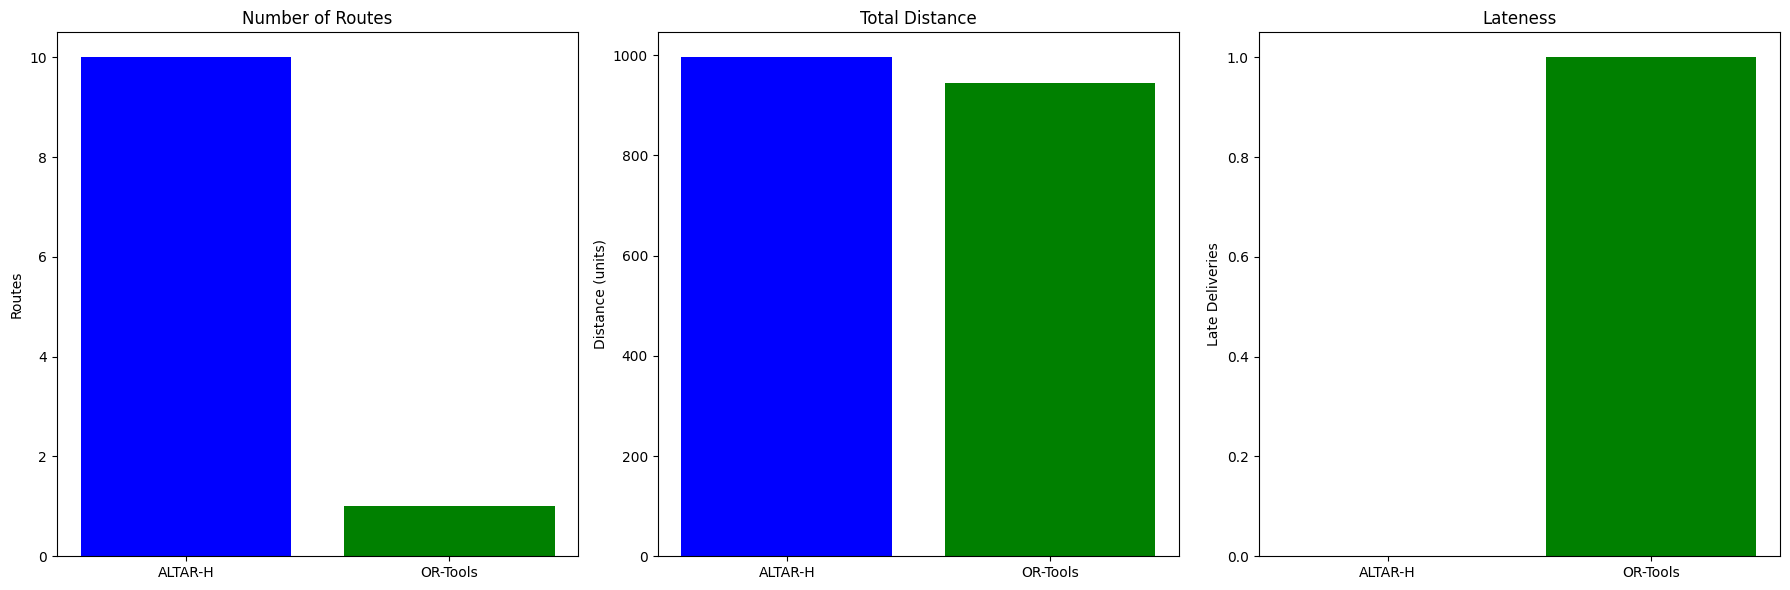

In [ ]:
import matplotlib.pyplot as plt
import json

# Load the results (replace with actual paths to your JSON files)
altarh_results_path = "/content/outputs/c101_altarh_kpis.json"
ortools_results_path = "/content/outputs/c101_ortools_kpis.json"

# Load JSON files
with open(altarh_results_path, 'r') as f:
    altarh_results = json.load(f)

with open(ortools_results_path, 'r') as f:
    ortools_results = json.load(f)

# Extract relevant data
altarh_routes = altarh_results["num_routes"]
altarh_distance = altarh_results["total_distance"]
altarh_late = altarh_results["late"]

ortools_routes = ortools_results["num_routes"]
ortools_distance = ortools_results["total_distance"]
ortools_late = ortools_results["late"]

# Create a bar chart for comparison
methods = ['ALTAR-H', 'OR-Tools']
routes = [altarh_routes, ortools_routes]
distances = [altarh_distance, ortools_distance]
lateness = [altarh_late, ortools_late]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot Route Comparison
ax[0].bar(methods, routes, color=['blue', 'green'])
ax[0].set_title("Number of Routes")
ax[0].set_ylabel("Routes")

# Plot Distance Comparison
ax[1].bar(methods, distances, color=['blue', 'green'])
ax[1].set_title("Total Distance")
ax[1].set_ylabel("Distance (units)")

# Plot Lateness Comparison
ax[2].bar(methods, lateness, color=['blue', 'green'])
ax[2].set_title("Lateness")
ax[2].set_ylabel("Late Deliveries")

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
\begin{table}[ht]
\centering
\caption{Comparison of Route Solutions: ALTAR-H vs OR-Tools}
\begin{tabular}{|c|c|c|c|}
\hline
\textbf{Method} & \textbf{Number of Routes} & \textbf{Total Distance (units)} & \textbf{Late Deliveries} \\
\hline
\textbf{ALTAR-H} & 10 & 995.99 & 0 \\
\hline
\textbf{OR-Tools} & 1 & 944.21 & 1 \\
\hline
\end{tabular}
\end{table}


SyntaxError: unexpected character after line continuation character (ipython-input-3636271863.py, line 1)

In [ ]:
from IPython.display import Latex
import pandas as pd

# Assuming df is your pandas DataFrame with the results
# If df is not available, you might need to load the CSV again:
# df = pd.read_csv("/content/outputs/batch_results.csv")

# Filter for the specific instance if needed, or use the full df
# For this example, I'll use the data for c101 as in the previous plot
c101_results = df[df['instance'] == 'c101']

# Start building the LaTeX table string
latex_table = """
\\begin{table}[ht]
\\centering
\\caption{Comparison of Route Solutions for c101: ALTAR-H vs OR-Tools}
\\begin{tabular}{|c|c|c|c|}
\\hline
\\textbf{Method} & \\textbf{Number of Routes} & \\textbf{Total Distance (units)} & \\textbf{Late Deliveries} \\\\
\\hline
"""

# Add data rows from the DataFrame
for index, row in c101_results.iterrows():
    latex_table += f"\\textbf{{{row['method']}}} & {row['routes']} & {row['distance']:.2f} & {row['late']} \\\\\n"
    latex_table += "\\hline\n"

# Close the LaTeX table string
latex_table += """
\\end{tabular}
\\end{table}
"""

# Display the LaTeX table
Latex(latex_table)

<IPython.core.display.Latex object>

In [ ]:
import pandas as pd
import json

# Define the paths to the results files for ALTAR-H and OR-Tools (replace with actual paths)
altarh_results_path = "/content/outputs/c101_altarh_kpis.json"
ortools_results_path = "/content/outputs/c101_ortools_kpis.json"

# Load JSON results
with open(altarh_results_path, 'r') as f:
    altarh_results = json.load(f)

with open(ortools_results_path, 'r') as f:
    ortools_results = json.load(f)

# Extract relevant data for the CSV table
methods = ['ALTAR-H', 'OR-Tools']
routes = [altarh_results["num_routes"], ortools_results["num_routes"]]
distances = [altarh_results["total_distance"], ortools_results["total_distance"]]
lateness = [altarh_results["late"], ortools_results["late"]]

# Create a DataFrame to hold the results
df = pd.DataFrame({
    'Method': methods,
    'Number of Routes': routes,
    'Total Distance (units)': distances,
    'Late Deliveries': lateness
})

# Save the DataFrame to a CSV file
csv_path = '/content/outputs/results_comparison.csv'
df.to_csv(csv_path, index=False)

print(f"CSV file saved at: {csv_path}")


CSV file saved at: /content/outputs/results_comparison.csv
